In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import os
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm as tqdm
import numpy as np
import seaborn as sns
from LabUtils.Utils import mkdirifnotexists

In [2]:
from LabData.DataAnalyses.TenK_Trajectories.biological_age.predict_age import modality_name_mapping, \
    work_dir, pred_dir, pred_residuals_fig_dir, load_ranked_residuals, Ys_dir, sm, r2_score, \
    BodyMeasuresLoader, add_text_at_corner, male_color, female_color
colors = {'Male': male_color, 'Female': female_color}

In [3]:
fig_dir = mkdirifnotexists(os.path.join(work_dir, 'figures', 'figure7'))

In [4]:
def load_real_vs_pred(x_name, sex):
    pred_col = 'age'
    
    y_df = pd.read_csv(os.path.join(Ys_dir, '%s.csv' % x_name), index_col=0).rename(columns={pred_col: 'true'})
    
    predictions_df = pd.read_csv(os.path.join(pred_dir, '%s_%s_equal-age' % (x_name, sex), 'cv_predictions_df.csv'), 
                                 index_col=0).rename(columns={pred_col: 'pred'})
    df = y_df.join(predictions_df[['pred']]).dropna()
    return df

n_bs = 1000
def bs_cov(x):
    res = []
    for i in range(n_bs):
        np.random.seed(i)
        x_temp = np.random.choice(x.stack(), x.shape[0], replace=True)
        res.append(x_temp.std() / x_temp.mean())
    res = pd.Series(res)
    return res.quantile([0.025, 0.5, 0.975])

def load_per_sex(x_name, sex):
    df = load_real_vs_pred(x_name, sex)
    df['age_bin'] = pd.cut(df['true'], bins=np.arange(40, 75, 5))
    # compute the coefficient of variation
    res = df.groupby('age_bin').apply(lambda x: x.std() / x.mean())
    count = df.groupby('age_bin').count()
    res = df[['pred', 'age_bin']].groupby('age_bin').apply(lambda x: bs_cov(x))
    res['sex'] = sex
    return res

def load_and_melt(x_name):
    print(x_name)
    res_male = load_per_sex(x_name, 'male')
    res_female = load_per_sex(x_name, 'female')
    res = pd.concat((res_male, res_female)).reset_index().melt(id_vars=['age_bin', 'sex'])
    res['age_bin'] = res[['age_bin']].astype(str).applymap(lambda x: x.replace('(', '').replace(']', '').replace(', ', '-') if 
                       isinstance(x, str) else x)['age_bin']
    
    return res


min_max = lambda x: (x.min(), x.max())

cat_to_exclude = ['diet_questions', 'medical_conditions', 'medications']


In [30]:
x_names = pd.read_csv(os.path.join(pred_dir, 'results.csv'), index_col=0).drop(cat_to_exclude).index

res_dic = {x_name: load_and_melt(x_name) for x_name in x_names}

blood_lipids
cardiovascular_system
immune_system
liver
renal_function
bone_density
microbiome
body_composition
frailty
lifestyle
diet
hematopoietic_system
glycemic_status
sleep


blood_lipids
cardiovascular_system
immune_system
liver
renal_function
bone_density
microbiome
body_composition
frailty
lifestyle
diet
hematopoietic_system
glycemic_status
sleep


/usr/wisdom/python-3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:35: UserWarning: FixedFormatter should only be used together with FixedLocator
/usr/wisdom/python-3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:56: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.


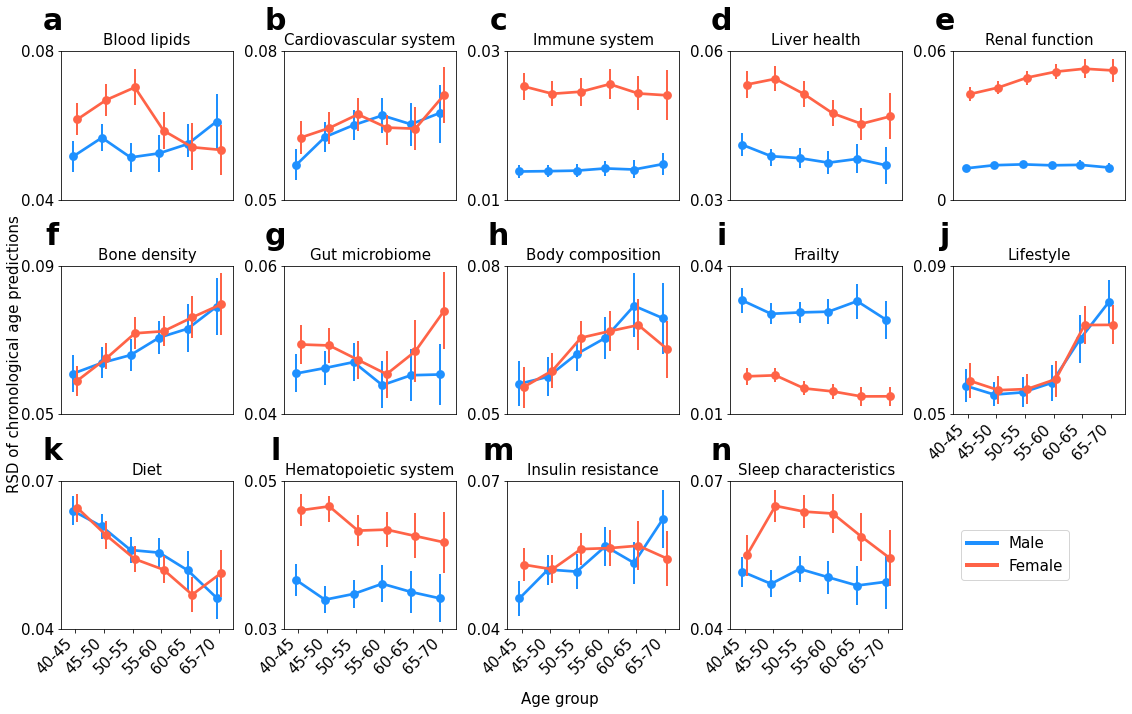

In [208]:
from matplotlib.ticker import FormatStrFormatter

fig, axes = plt.subplots(3, 5, figsize=(16, 10), sharex=False, sharey=False, constrained_layout=True)

x_names = pd.read_csv(os.path.join(pred_dir, 'results.csv'), index_col=0).drop(cat_to_exclude).index
pred_col = 'age'

for x_name, ax, letter in zip(x_names, axes.flatten(), 'abcdefghijklmno'):
    print(x_name)
    res = res_dic[x_name]
    
    sns.pointplot(data=res, x='age_bin', y='value', hue='sex', errorbar=min_max, join=True,
                  dodge=0.15, errwidth=2, ax=ax, palette=[male_color, female_color])

    ax.set_ylabel('')
    ax.set_xlabel('', fontsize=15)
    
    ax.legend().set_visible(False)
    
    ax.axes.get_xaxis().set_visible(False)

    ax.set_title(modality_name_mapping[x_name], fontsize=15)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
    ax.set_yticks((ax.get_yticks().min(), ax.get_yticks().max()))
    ax.yaxis.set_major_formatter(FormatStrFormatter('%.1g'))


    ax.tick_params(labelsize=15)
    if letter != 'o':
        ax.text(-0.05, 1.2, letter, ha='center', va='center', transform=ax.transAxes, fontsize=30, weight='bold')
    
for ax_i in range(5):
    ax = axes[-1, ax_i]
    ax.axes.get_xaxis().set_visible(True)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
    
    
ax = axes[-1, -1]
ax.axis('off')

# costume legend
from matplotlib.lines import Line2D
custom_lines = [Line2D([0], [0], color=male_color, lw=4),
                Line2D([0], [0], color=female_color, lw=4)]

ax.legend(custom_lines, ['Male', 'Female'], ncol=1, bbox_to_anchor=(0, 0.5), fancybox=True, 
          fontsize=15, loc='center left')

ax = axes[1, -1]
ax.axes.get_xaxis().set_visible(True)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')

fig.supxlabel('Age group', fontsize=15)
fig.supylabel('RSD of chronological age predictions', fontsize=15)

fig.tight_layout()

plt.savefig(os.path.join(fig_dir, 'figure7.png'), dpi=300, bbox_inches='tight')
plt.savefig(os.path.join(fig_dir, 'figure7.pdf'), dpi=300, bbox_inches='tight')

In [34]:
from joypy import joyplot

In [87]:
def load_residuals(x_name):
    df_list = []
    for sex in ['male', 'female']:
        pred_col = 'age'

        y_df = pd.read_csv(os.path.join(Ys_dir, '%s.csv' % x_name), index_col=0).rename(columns={pred_col: 'true'})

        residuals = pd.read_csv(os.path.join(pred_dir, '%s_%s_equal-age' % (x_name, sex), 'residuals.csv'), index_col=0)
        df = y_df.join(residuals[['residuals centered']]).dropna().rename(columns={'residuals centered': sex})
#         df['sex'] = sex
        df_list.append(df)
    return pd.concat(df_list, axis=0)


df = load_residuals('bone_density')

df['age_bin'] = pd.cut(df['true'], bins=np.arange(40, 76, 5))
df.sort_values('age_bin', inplace=True)
df['age_bin'] = df[['age_bin']].astype(str).applymap(lambda x: x.replace('(', '').replace(']', '').replace(', ', '-') if 
                       isinstance(x, str) else x)['age_bin']
df

,true,male,female,age_bin
RegistrationCode,,,,
10K_9999226141,42.957761,-1.807829,NaN,40-45
10K_8664417184,44.797634,-5.458338,NaN,40-45
10K_8655388519,43.352020,1.612565,NaN,40-45
10K_8635924514,42.957761,-2.304739,NaN,40-45
10K_8634478644,40.967303,-2.895619,NaN,40-45
...,...,...,...,...
10K_4906709857,73.104855,0.830438,NaN,70-75
10K_4989250468,72.340979,NaN,-1.478788,70-75
10K_5404450723,71.388187,-0.492672,NaN,70-75


In [168]:
def ridgeline_plot(x_name):

    df = load_residuals(x_name)

    df['age_bin'] = pd.cut(df['true'], bins=np.arange(40, 76, 5))
    df.sort_values('age_bin', inplace=True)
    df['age_bin'] = df[['age_bin']].astype(str).applymap(lambda x: x.replace('(', '').replace(']', '').replace(', ', '-') if 
                           isinstance(x, str) else x)['age_bin']

    fig, axes = joyplot(
        data=df, 
        by='age_bin',
        column=['male', 'female'],
        color=[male_color, female_color],
        legend=True,
        alpha=0.7,
#         overlap=1, kind="normalized_counts", bins=30,
        figsize=(6, 4)
    )

    plt.title('', fontsize=20)
    # plt.legend(loc='upper left')
    plt.xlabel('Biological aging scores', fontsize=15)
    for ax in axes:
        ax.tick_params(labelsize=15)
    axes[0].legend(fontsize=15, loc='upper right')
    fig.supylabel('Age group', fontsize=15, x=-0.05)
    plt.title(modality_name_mapping[x_name], fontsize=15)
    # plt.xticks(fontsize=15)
    # plt.yticks(fontsize=15)
    # plt.tight_layout()
    plt.savefig(os.path.join(fig_dir, 'ridgeline_plot_%s.png' % x_name), dpi=300, bbox_inches='tight')
    plt.savefig(os.path.join(fig_dir, 'ridgeline_plot_%s.pdf' % x_name), dpi=300, bbox_inches='tight')
    

In [158]:
x_names = pd.read_csv(os.path.join(pred_dir, 'results.csv'), index_col=0).drop(cat_to_exclude).index

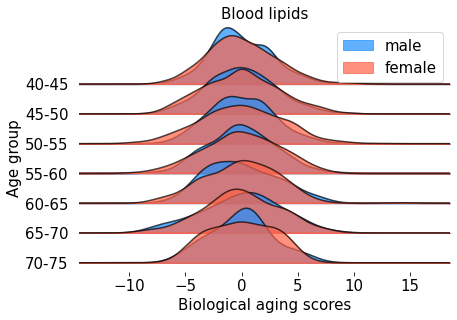

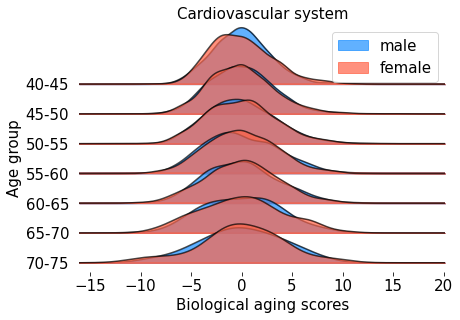

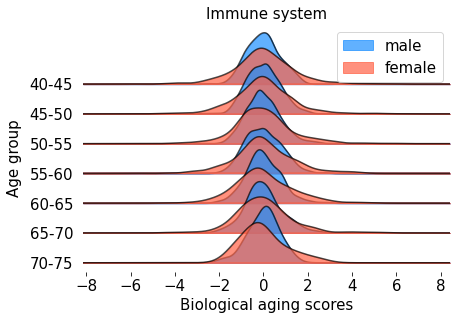

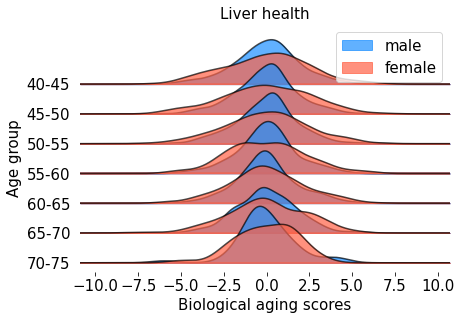

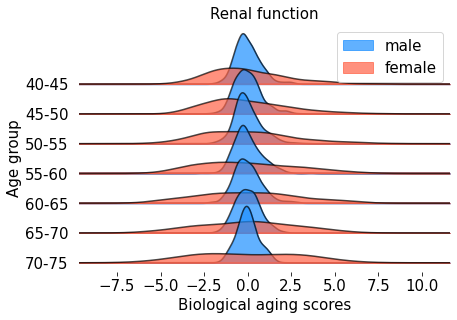

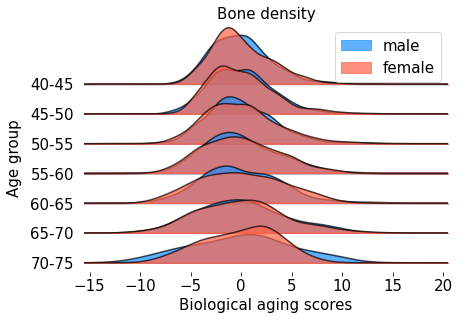

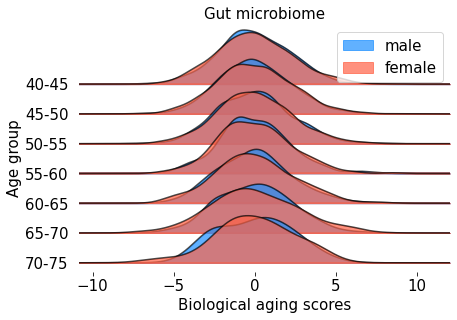

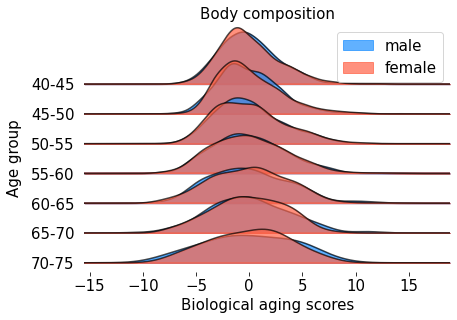

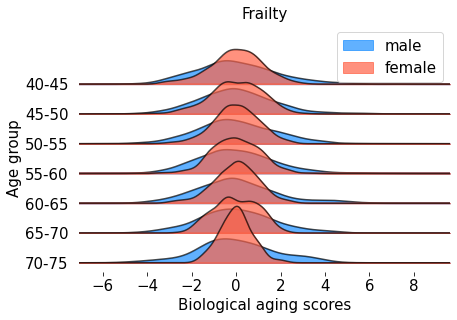

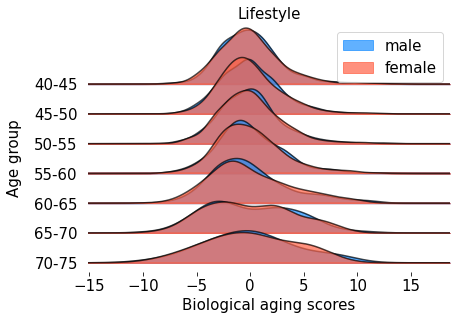

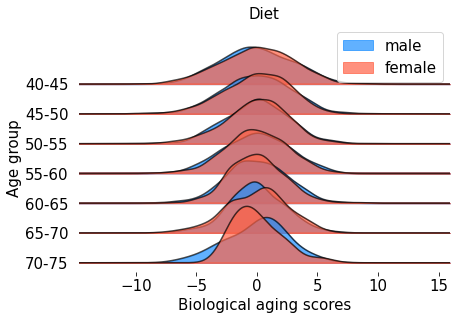

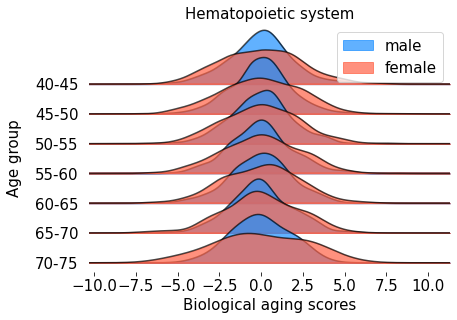

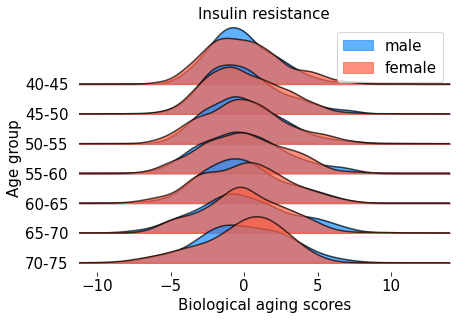

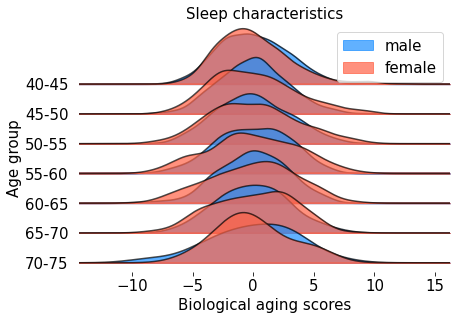

In [169]:
for x_name in x_names:
    ridgeline_plot(x_name)

blood_lipids
cardiovascular_system
immune_system
liver


/usr/wisdom/python-3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:53: UserWarning: FixedFormatter should only be used together with FixedLocator
/usr/wisdom/python-3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:53: UserWarning: FixedFormatter should only be used together with FixedLocator
/usr/wisdom/python-3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:53: UserWarning: FixedFormatter should only be used together with FixedLocator
/usr/wisdom/python-3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:53: UserWarning: FixedFormatter should only be used together with FixedLocator


renal_function
bone_density
microbiome
body_composition


/usr/wisdom/python-3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:53: UserWarning: FixedFormatter should only be used together with FixedLocator
/usr/wisdom/python-3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:53: UserWarning: FixedFormatter should only be used together with FixedLocator
/usr/wisdom/python-3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:53: UserWarning: FixedFormatter should only be used together with FixedLocator
/usr/wisdom/python-3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:53: UserWarning: FixedFormatter should only be used together with FixedLocator


frailty
lifestyle
diet
hematopoietic_system


/usr/wisdom/python-3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:53: UserWarning: FixedFormatter should only be used together with FixedLocator
/usr/wisdom/python-3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:53: UserWarning: FixedFormatter should only be used together with FixedLocator
/usr/wisdom/python-3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:53: UserWarning: FixedFormatter should only be used together with FixedLocator
/usr/wisdom/python-3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:53: UserWarning: FixedFormatter should only be used together with FixedLocator


glycemic_status
sleep


/usr/wisdom/python-3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:53: UserWarning: FixedFormatter should only be used together with FixedLocator
/usr/wisdom/python-3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:53: UserWarning: FixedFormatter should only be used together with FixedLocator
/usr/wisdom/python-3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:82: UserWarning: FixedFormatter should only be used together with FixedLocator
/usr/wisdom/python-3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:87: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.


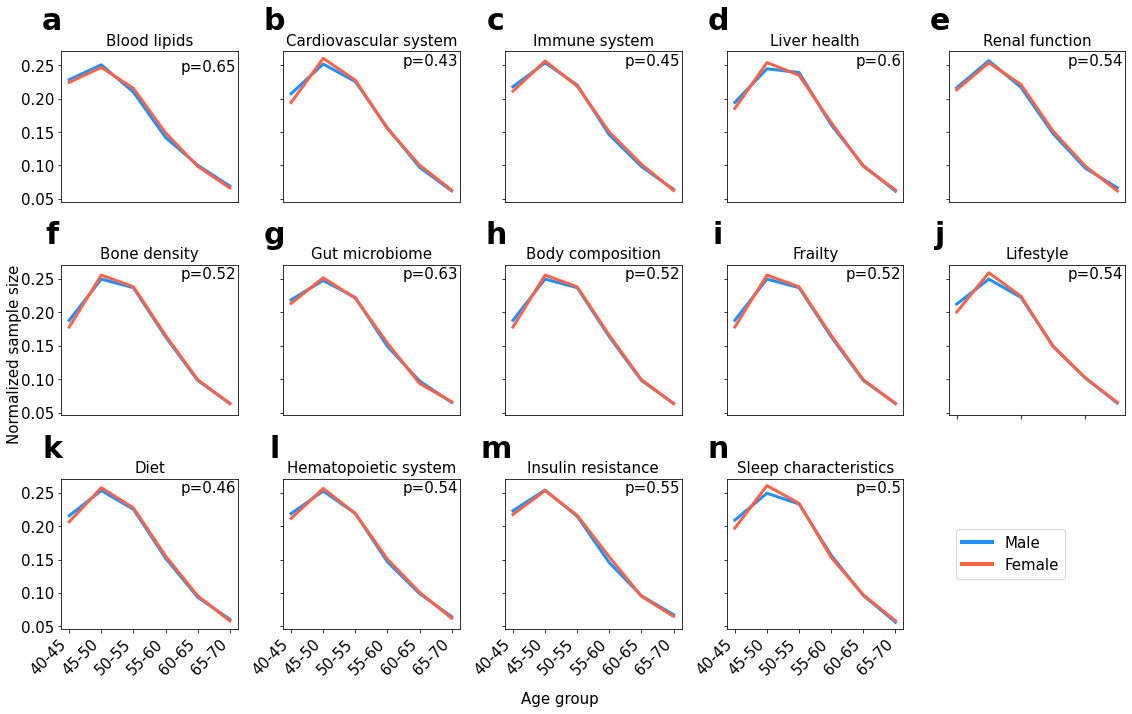

In [58]:
x_names = pd.read_csv(os.path.join(pred_dir, 'results.csv'), index_col=0).drop(cat_to_exclude).index


# colors = sns.color_palette('Paired', len(x_names) * 2)
# fig, axes = plt.subplots(3, 5, figsize=(16, 10), sharex=False, sharey=False, constrained_layout=True)

# for x_name, ax in zip(x_names, axes.flatten()):
#     for sex, sex_color in zip(['male', 'female'], [male_color, female_color]):
#         df = load_real_vs_pred(x_name, sex)
#         df['age_bin'] = pd.cut(df['true'], bins=np.arange(40, 75, 5))
#         df = df[['true', 'age_bin']].groupby('age_bin').count()
#         ax.plot(range(df.shape[0]), df['true'] / df['true'].sum(), 
#                 label=sex, color=sex_color)
#         ax.set_title(modality_name_mapping[x_name])
#         ax.legend()
#         ax.plot


from matplotlib.ticker import FormatStrFormatter
from scipy.stats import mannwhitneyu

fig, axes = plt.subplots(3, 5, figsize=(16, 10), sharex=False, sharey=True, constrained_layout=True)

x_names = pd.read_csv(os.path.join(pred_dir, 'results.csv'), index_col=0).drop(cat_to_exclude).index
pred_col = 'age'
unique_ids = []

for x_name, ax, letter in zip(x_names, axes.flatten(), 'abcdefghijklmno'):
    print(x_name)
#     res = res_dic[x_name]
    
#     sns.pointplot(data=res, x='age_bin', y='value', hue='sex', errorbar=min_max, join=True,
#                   dodge=0.15, errwidth=2, ax=ax, palette=[male_color, female_color])
    ages = []
    for sex, sex_color in zip(['male', 'female'], [male_color, female_color]):
        df = load_real_vs_pred(x_name, sex)
        ages.append(df['true'].dropna().values.tolist())
        unique_ids.append(pd.Series(df.index))
        df['age_bin'] = pd.cut(df['true'], bins=np.arange(40, 75, 5))
        df = df[['true', 'age_bin']].groupby('age_bin').count()
        ax.plot(range(df.shape[0]), df['true'] / df['true'].sum(), 
                label=sex, color=sex_color, linewidth=3, linestyle='-')
    t, p = mannwhitneyu(ages[0], ages[1])
    add_text_at_corner(ax, 'p=%0.2g' % p, 'top right', fontsize=15)
    ax.set_ylabel('')
    ax.set_xlabel('', fontsize=15)
    
    ax.legend().set_visible(False)
    
    ax.axes.get_xaxis().set_visible(False)

    ax.set_title(modality_name_mapping[x_name], fontsize=15)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
#     ax.set_yticks((ax.get_yticks().min(), ax.get_yticks().max()))
#     ax.yaxis.set_major_formatter(FormatStrFormatter('%.1g'))


    ax.tick_params(labelsize=15)
    if letter != 'o':
        ax.text(-0.05, 1.2, letter, ha='center', va='center', transform=ax.transAxes, fontsize=30, weight='bold')
    
for ax_i in range(5):
    ax = axes[-1, ax_i]
    ax.axes.get_xaxis().set_visible(True)
    ax.set_xticks(range(6))
    ax.set_xticklabels(["40-45", "45-50", "50-55", "55-60", "60-65", "65-70"], rotation=45, ha='right')
    
    
ax = axes[-1, -1]
ax.axis('off')

# costume legend
from matplotlib.lines import Line2D
custom_lines = [Line2D([0], [0], color=male_color, lw=4),
                Line2D([0], [0], color=female_color, lw=4)]

ax.legend(custom_lines, ['Male', 'Female'], ncol=1, bbox_to_anchor=(0, 0.5), fancybox=True, 
          fontsize=15, loc='center left')

ax = axes[1, -1]
ax.axes.get_xaxis().set_visible(True)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')

fig.supxlabel('Age group', fontsize=15)
fig.supylabel('Normalized sample size', fontsize=15)

fig.tight_layout()

plt.savefig(os.path.join(fig_dir, 'figure7_samplesizes.png'), dpi=300, bbox_inches='tight')
plt.savefig(os.path.join(fig_dir, 'figure7_samplesizes.pdf'), dpi=300, bbox_inches='tight')

In [60]:
pd.concat(unique_ids).value_counts()

10K_9355958873    14
10K_3667402233    14
10K_7833168704    14
10K_3359110123    14
10K_8223108292    14
                  ..
10K_5338994641     1
10K_9357634144     1
10K_9511558173     1
10K_9982838880     1
10K_9888733666     1
Name: RegistrationCode, Length: 10348, dtype: int64

In [10]:
x_names = pd.read_csv(os.path.join(pred_dir, 'results.csv'), index_col=0).drop(cat_to_exclude).index
pred_col = 'age'

for x_name, ax, letter in zip(x_names, axes.flatten(), 'abcdefghijklmno'):
    print(x_name)
#     res = res_dic[x_name]
    
#     sns.pointplot(data=res, x='age_bin', y='value', hue='sex', errorbar=min_max, join=True,
#                   dodge=0.15, errwidth=2, ax=ax, palette=[male_color, female_color])
    for sex, sex_color in zip(['male', 'female'], [male_color, female_color]):
        df = load_real_vs_pred(x_name, sex)
        df['age_bin'] = pd.cut(df['true'], bins=np.arange(40, 75, 5))
        df = df[['true', 'age_bin']].groupby('age_bin').count()
        ax.plot(range(df.shape[0]), df['true'] / df['true'].sum(), 
                label=sex, color=sex_color, linewidth=3, linestyle='-')

,true
age_bin,
"(40, 45]",671
"(45, 50]",891
"(50, 55]",845
"(55, 60]",583
"(60, 65]",350
"(65, 70]",228


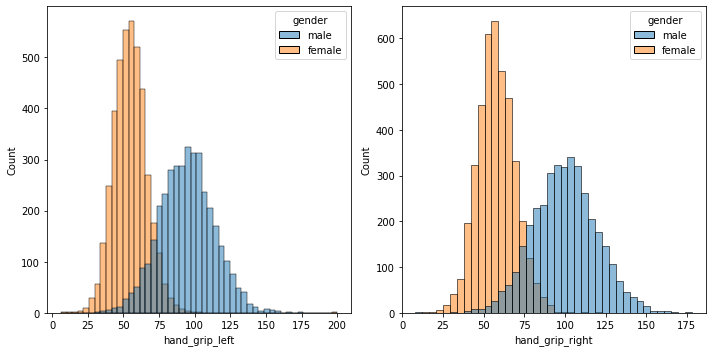

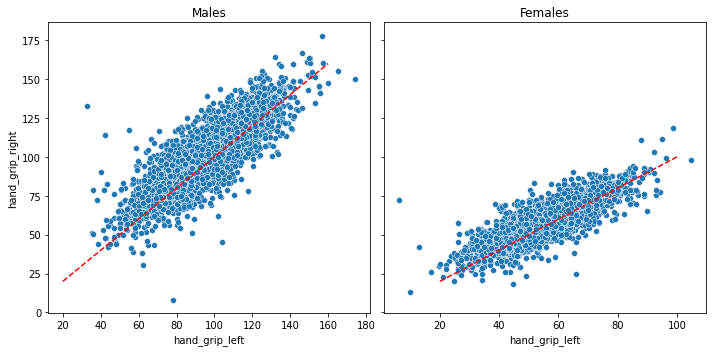

In [193]:
f = pd.read_csv(os.path.join(work_dir, 'Xs', 'frailty.csv'), index_col=0).replace({'gender': {0: 'female', 1: 'male'}})

fig, axes = plt.subplots(1, 2, figsize=(10, 5))
f['hand_grip_left'] = f['hand_grip_left'].clip(upper=200)
f['hand_grip_right'] = f['hand_grip_right'].clip(upper=200)

sns.histplot(data=f, x='hand_grip_left', hue='gender', ax=axes[0])
sns.histplot(data=f, x='hand_grip_right', hue='gender', ax=axes[1])

fig.tight_layout()
plt.savefig('/home/noamba/hand_grip_distributions.png', dpi=300)
plt.show()

fig, axes = plt.subplots(1, 2, figsize=(10, 5), sharey=True)
sns.scatterplot(data=f[f.gender == 'male'], x='hand_grip_left', y='hand_grip_right', ax=axes[0])
axes[0].set_title('Males')
axes[0].plot([20, 160], [20, 160], '--', color='red')
sns.scatterplot(data=f[f.gender == 'female'], x='hand_grip_left', y='hand_grip_right', ax=axes[1])
axes[1].set_title('Females')
axes[1].plot([20, 100], [20, 100], '--', color='red')
fig.tight_layout()
plt.savefig('/home/noamba/hand_grip_scatterplots.png', dpi=300)
plt.show()